# Battle of the Neighbourhoods Final Project

Welcome to this notebook introducing the final project in my IBM Data Science course. 

## Introduction
Home is the most important place in the world for most people, but there may come a time where you can no longer call this place your home. Hundreds of thousands of people every year find themselves in the position, and may no longer be able to rely on their local steakhouse, chinese or sushi bar to get their weekly fix. They will be sorely missed!  

<img src="london.jpg" alt="London" width="500"/>

### The Problem  
London is the hub of the UK, it is the centre of beautiful views, west end performances, business conferences and (most importantly) places to eat. In this project I would like to explore the areas of London by utilising data from the **Foursquare** API, and use segmentation and clustering to discover the areas of London that are most like our own.

#### Approach
+ Collect geospatial data from our sources.
+ Use Foursquare API to find the specific venues we require for each area.
+ Find location and categories of venues.
+ Use K-means clustering to create clusters of venues.
+ Locate rental price data for London.
+ Plot choropleth map of rental price density.
+ Visualize the clusters of most similar areas along with rental prices on same plot.

## Data
Firstly, we need some data about the different areas and postal codes in London, which I have managed to find a detailed table on Wikipedia.
> https://en.wikipedia.org/wiki/List_of_areas_of_London 

Secondly, we require some detailed location data regarding the postal codes that we have collected.
> We shall use python library **Geopy** to extract this data.

Finally, we can use the Foursquare API to grab details of the venues that are within these areas, full documentation can be found below.
> https://foursquare.com  

Next, I found great rental data for 2011 through to 2019 available on the Gov UK website in the form of an excel file.
> https://data.london.gov.uk/dataset/average-private-rents-borough

Another great source of data to help with this project was found on the Github page below. This provided the GeoJSON file for all of the London boroughs, that is, the coordinates for the boundaries surrounding a particular area.
> https://skgrange.github.io/data.html

## Libraries
Below I load all of the Python libraries I have used in the completion of this task. 

In [1]:
# Main Python libraries for data analysis
import pandas as pd
import numpy as np
import math
import seaborn as sns

# Machine learning module for building K-means clusters
from sklearn.cluster import KMeans

# Library for parsing HTML code
from bs4 import BeautifulSoup

# Library to handle requests
import requests
from requests import get

# Library for building maps from geospatial data
import folium

# Transform json file to pandas dataframe
from pandas.io.json import json_normalize

# maplotlib and associated modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# Get coordinates of given addresses
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

# Create wordclouds from text
from wordcloud import WordCloud

print('Libraries imported!')

Libraries imported!


## Data Acquisition
In our approach, we discuss the first task at hand is to collect the data and ensure that it is appropriate for us to use. I found the details of all the postal codes with approriate neighbourhood names assigned on the Wikipedia page outlined above in our data section.  

Of course, we may acknowledge that Wikipedia is not the most reliable data source for most of our projects, it is reasonable to assume that the data provided on this topic is going to be good enough for us to complete this task.

In [2]:
# Get response from url
url = 'https://en.wikipedia.org/wiki/List_of_areas_of_London'
response = get(url)

# Initialise BeautifulSoup to read our html text.
soup = BeautifulSoup(response.text, 'html.parser')
print('Read postal data into HTML.')

Read postal data into HTML.


#### Extract table with postal codes
After reviewing the source code for our Wikipedia page, I notice the table with the data I require has the unique table class *wikitable sortable* and thus can extract the data from this table. Following this, I iterate through the individual rows of the extracted data and append them to a Python list ready for manipulation.

In [3]:
# Find the table we need from our wikipage, class name 'wikitable sortable'
data = []
table = soup.find('table', {'class':'wikitable sortable'})
table_body = table.find('tbody')

# Iterate through the table and append all table rows and columns to list called 'data'
rows = table_body.find_all('tr')
for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    data.append([ele for ele in cols if ele]) # Get rid of empty values
    
# Print first 6 rows of list 'data'
data[0:6]

[[],
 ['Abbey Wood', 'Bexley,  Greenwich [7]', 'LONDON', 'SE2', '020', 'TQ465785'],
 ['Acton',
  'Ealing, Hammersmith and Fulham[8]',
  'LONDON',
  'W3, W4',
  '020',
  'TQ205805'],
 ['Addington', 'Croydon[8]', 'CROYDON', 'CR0', '020', 'TQ375645'],
 ['Addiscombe', 'Croydon[8]', 'CROYDON', 'CR0', '020', 'TQ345665'],
 ['Albany Park', 'Bexley', 'BEXLEY, SIDCUP', 'DA5, DA14', '020', 'TQ478728']]

#### Converting to dataframe
This information is brilliant, however it is more useful in a Pandas dataframe so that we can use the Python library to perform data processing and analysis tasks on the data.  

- Firstly, notice that the first entry of our Python list is empty and can easily be dropped inplace.  (Drop row 0)
- Next, notice is that the London Borough, which will be used as our location data, contains alphanumeric data, of which the number has no meaning for the context of this problem. (Remove numeric values from London Borough)

In [4]:
# Use pandas to convert list to dataframe
df = pd.DataFrame(data).drop(axis = 0, index = 0)
df.rename(columns = {0:'Location',1:'London Borough',2:'Post Town',3:'Postcode',4:'Dial Code',5:'OS Grid Ref'}, inplace = True)

# Drop columns that aren't neccessary
df.drop(columns = {'Dial Code','OS Grid Ref'}, inplace = True)

# Combine rows with boroughs that are the same
df['London Borough'] = df['London Borough'].str.split('[').str.get(0)
#df['Postcode'] = df['Postcode'].str.split(',').str.get(0)
df['London Borough'] = df['London Borough'].str.split(', ').str.get(0) + ', London, UK'
df = df.groupby(['London Borough'])['Postcode'].apply(', '.join).reset_index()

# Print first five rows
print('Rows: {}, Columns: {}'.format(df.shape[0],df.shape[1]))
df.head()

Rows: 38, Columns: 2


London Borough  \
0  Barking and Dagenham, London, UK   
1                Barnet, London, UK   
2                Bexley, London, UK   
3                 Brent, London, UK   
4               Bromley, London, UK   

                                            Postcode  
0     IG11, RM9, RM8, RM9, IG11, RM9, RM10, RM6, RM7  
1  EN5, NW7, NW7, EN5, EN5, NW2, NW4, N11, HA8, N...  
2  SE2, DA5, DA14, DA7, DA1, DA17, DA5, DA6, DA7,...  
3  HA0, NW10, NW6, NW10, NW2, NW10, NW10, NW6, HA...  
4  SE20, TN16, BR3, SE20, BR3, TN16, BR1, BR3, BR...

#### Request location data
Now we have our 38 unique boroughs of London in our dataframe, we can initialise calls to retrieve data from the Geopy geolacation service. Begin by requesting the individual location data of all the boroughs and retrieve the latitude and longitude data for each data point.  

For a large amount of data this could possibly take a long time and may sometimes fail, therefore I am assigning the values to a spreadsheet so that I do not need to request this again.

In [5]:
locator = Nominatim(user_agent='myGeocoder')

# Delay between calls to geocoder, stops error for too many requests
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)

# Create address column
df['Address'] = df['London Borough'].apply(geocode)

# Get lat, long and alt from address.
df['Point'] = df['Address'].apply(lambda loc: tuple(loc.point) if loc else None)

# Split the tuple above into columns in df.
df[['Latitude', 'Longitude', 'Altitude']] = pd.DataFrame(df['Point'].tolist(), index=df.index)
df.drop(columns = ['Address','Altitude','Point'], inplace = True)

df.to_csv('LDN_Coords.csv')
ldnDF = df

print('Location data found.')

Location data found.


#### Missing location data
It is possible that the service provider may not find locations for all of our data points. The two points that did not respond with any location data are **Haringey and Barnet** and **Kensington and Chelsea, Hammersmith and Fulham**. Since I know that there are other points in the dataset that correspond with Barnet and Kensington, I have decided to drop these two rows, leaving 36 London boroughs.

In [6]:
# View rows with missing values
ldnDF[ldnDF.isnull().any(axis=1)]

London Borough Postcode  Latitude  \
15                    Haringey and Barnet, London, UK      N10       NaN   
24  Kensington and ChelseaHammersmith and Fulham, ...      SW3       NaN   

    Longitude  
15        NaN  
24        NaN

In [7]:
# Drop rows with missing values
ldnDF.dropna(inplace = True)

In [8]:
ldnDF.head()

London Borough  \
0  Barking and Dagenham, London, UK   
1                Barnet, London, UK   
2                Bexley, London, UK   
3                 Brent, London, UK   
4               Bromley, London, UK   

                                            Postcode   Latitude  Longitude  
0     IG11, RM9, RM8, RM9, IG11, RM9, RM10, RM6, RM7  51.554117   0.150504  
1  EN5, NW7, NW7, EN5, EN5, NW2, NW4, N11, HA8, N...  51.653090  -0.200226  
2  SE2, DA5, DA14, DA7, DA1, DA17, DA5, DA6, DA7,...  51.441679   0.150488  
3  HA0, NW10, NW6, NW10, NW2, NW10, NW10, NW6, HA...  51.563826  -0.275760  
4  SE20, TN16, BR3, SE20, BR3, TN16, BR1, BR3, BR...  51.402805   0.014814

#### Visualising Geospatial Data
Now the dataframe contains longitude and latitude data, we are able to use Python library Folium to create a visualisation of the centre of the London Boroughs we have extracted.  

One thing to notice is that the closer to the centre of London, the more boroughs that exist, that is that the borough begin to almost overlap in the visual sense, and therefore it might be wise to increase neighbourhood radius the further from the centre.

In [9]:
# Create a map of London using latitude and longitude values found above
latitude = 51.5156177
longitude = -0.0919983
MapLondon = folium.Map(location = [latitude, longitude], zoom_start = 10)

# Add the markers for each entry in our London dataset
for lat, lng, location, borough in zip(ldnDF['Latitude'], ldnDF['Longitude'], ldnDF['London Borough'], ldnDF['Postcode']):
    label = '{}'.format(location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.4,
        parse_html=False).add_to(MapLondon)  

MapLondon

### Request Venue Data from Foursquare API
Now that the London borough data is in the format that we need and we have location values for the corresponding boroughs, we can initialise the process for gaining details of venues that are closeby.  

Begin by looking at only the first data point in our dataset, which as below is Barking and Dagenham, London, UK. By looking at only a single entry, we can confirm the data we are retrieving is applicable to the problem.

In [10]:
# Get lat, long and name of first borough
locationLat, locationLon, boroughName = ldnDF.loc[0, 'Latitude'], ldnDF.loc[0, 'Longitude'], ldnDF.loc[0, 'London Borough']

print('Latitude and longitude values of {} are {}, {}.'.format(boroughName, locationLat, locationLon))

Latitude and longitude values of Barking and Dagenham, London, UK are 51.5541171, 0.15050434261994267.


#### Foursquare
Firstly, sign up for Foursquare and set up credentials in the notebook so that requests can be made. Of course, actual credentials will be blocked out for the publishing of this notebook.

In [11]:
# Foursquare credentials
CLIENT_ID = 'S3MVMBIWUB0QXTOQULOJFL3LNOEIUJVDPEW401HUKTOBVQA0'
CLIENT_SECRET = 'LFZGNDTO1JWYLPAWZU1IKAG4IRSQ0Z5KNRPJBQYWM5DDKSPK'
VERSION = '20180604'
LIMIT = 100
radius = 1000

#### Sending request for venue data
Now use the information given by the Foursquare website to create unique URL link to request the data we need. 

In [12]:
# Create Foursquare URL to retrieve data
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&section={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    locationLat, 
    locationLon,
    'food',
    radius, 
    LIMIT)

# Request data from API
results = requests.get(url).json()

#### Extract venue cateogry from JSON
The request form this API will provide the results in a JSON file and after examination, we can write the following code to extract the venue category for each individual result.

In [13]:
# Function to retrieve venue categories from result set
def getCategory(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Putting these results into a dataframe makes it a lot easier to read.

In [14]:
# Extract only venues from JSON results and noramlise to dataframe
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)

# Extract only neccessary columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# Apply get category type to each row
nearby_venues['venue.categories'] = nearby_venues.apply(getCategory, axis=1)

# Clean the columns and view results
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
print(nearby_venues.shape)
nearby_venues.head()

(6, 4)


/Users/christian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


name          categories        lat       lng
0       Lara Grill  Turkish Restaurant  51.562445  0.147178
1        snack bar                Café  51.552840  0.147773
2   Heath Pie Shop               Diner  51.560414  0.147655
3  The Golden Fish   Fish & Chips Shop  51.560512  0.147334
4            Tarka   Indian Restaurant  51.552033  0.162370

##### Repeat process for all London borough's
This is the dataframe format that we require and the categories are labelled, now we need to repeat this process for each London Borough. Create a function **getNearbyVenues** that repeats the process above and loop through all borough's.

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius, section = 'food'):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # Create Foursquare URL to retrieve data
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&section={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            section,
            radius, 
            LIMIT)
            
        # Request data from API
        results = requests.get(url).json()['response']['groups'][0]['items']
            
        # Extract relevant information from JSON response
        venues_list.append([(
            name, 
            lat, 
            lng,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            ) for v in results])

    # Return the relevant columns in dataframe format for each venue in the list
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Latitude', 
                  'Longitude',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
# Iterate through locations in london dataframe
ldnFood = getNearbyVenues(names = ldnDF['London Borough'],
                                   latitudes = ldnDF['Latitude'],
                                   longitudes = ldnDF['Longitude'],
                                  radius = 1000
                                  )

Barking and Dagenham, London, UK
Barnet, London, UK
Bexley, London, UK
Brent, London, UK
Bromley, London, UK
Camden and Islington, London, UK
Camden, London, UK
City, London, UK
Croydon, London, UK
Dartford, London, UK
Ealing, London, UK
Enfield, London, UK
Greenwich, London, UK
Hackney, London, UK
Hammersmith and Fulham, London, UK
Haringey, London, UK
Harrow, London, UK
Havering, London, UK
Hillingdon, London, UK
Hounslow, London, UK
Islington & City, London, UK
Islington, London, UK
Kensington and Chelsea, London, UK
Kingston upon Thames, London, UK
Lambeth, London, UK
Lewisham, London, UK
Merton, London, UK
Newham, London, UK
Redbridge, London, UK
Richmond upon Thames, London, UK
Southwark, London, UK
Sutton, London, UK
Tower Hamlets, London, UK
Waltham Forest, London, UK
Wandsworth, London, UK
Westminster, London, UK


### Food Venue Output
Let's look at the output of our function that has completed above. We can see 1951 total venues have been returned.

In [17]:
print(ldnFood.shape)
ldnFood.head()

(1951, 7)


Borough   Latitude  Longitude            Venue  \
0  Barking and Dagenham, London, UK  51.554117   0.150504       Lara Grill   
1  Barking and Dagenham, London, UK  51.554117   0.150504        snack bar   
2  Barking and Dagenham, London, UK  51.554117   0.150504   Heath Pie Shop   
3  Barking and Dagenham, London, UK  51.554117   0.150504  The Golden Fish   
4  Barking and Dagenham, London, UK  51.554117   0.150504            Tarka   

   Venue Latitude  Venue Longitude      Venue Category  
0       51.562445         0.147178  Turkish Restaurant  
1       51.552840         0.147773                Café  
2       51.560414         0.147655               Diner  
3       51.560512         0.147334   Fish & Chips Shop  
4       51.552033         0.162370   Indian Restaurant

#### Count of Venues
As with all data problems, the more data there is the more accurate the assumptions we can make from them will be. Looking at the count of the number of venues for each borough will therefore be important.  

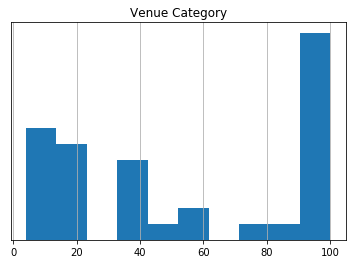

In [18]:
# Groupby borough and count number of entries
boroughGroup = ldnFood.groupby('Borough', as_index = False).count()
boroughGroup[['Borough','Venue Category']].hist()
plt.yticks([])
plt.show()

In [19]:
print('There are {} unique categories.'.format(len(ldnFood['Venue Category'].unique())))

There are 100 unique categories.


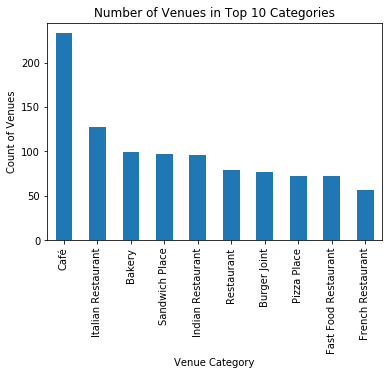

In [20]:
groupCategory = ldnFood.groupby('Venue Category', as_index = False).count().sort_values('Venue', ascending = False)
plotCategory = groupCategory.head(10)
plotCategory.set_index('Venue Category', inplace = True)

# Use matplotlib to plot top occurring food venues
plotCategory['Venue'].plot(kind = 'bar')
plt.title('Number of Venues in Top 10 Categories')
plt.ylabel('Count of Venues')
plt.xlabel('Venue Category')
plt.show()

### Data Preparation
All of the data required has now been collected, begin analysing the data and prepare it for clustering.  

One hot encoding is used to convert the categoric data stored in the column **Venue Category** into numeric data so that it can be used for analysis.

In [21]:
# One hot encoding of venue category
ldnOneHot = pd.get_dummies(ldnFood[['Venue Category']], prefix="", prefix_sep="")

# Add borough column back to dataframe
ldnOneHot['Borough'] = ldnFood['Borough']

# Move borough column back to first column
borough = ldnOneHot['Borough']
ldnOneHot.drop(columns = {'Borough'}, inplace = True)
ldnOneHot.insert(0, 'Borough', borough)

print(ldnOneHot.shape)
ldnOneHot.head()

(1951, 101)


Borough  Afghan Restaurant  African Restaurant  \
0  Barking and Dagenham, London, UK                  0                   0   
1  Barking and Dagenham, London, UK                  0                   0   
2  Barking and Dagenham, London, UK                  0                   0   
3  Barking and Dagenham, London, UK                  0                   0   
4  Barking and Dagenham, London, UK                  0                   0   

   American Restaurant  Argentinian Restaurant  Asian Restaurant  \
0                    0                       0                 0   
1                    0                       0                 0   
2                    0                       0                 0   
3                    0                       0                 0   
4                    0                       0                 0   

   Australian Restaurant  Austrian Restaurant  BBQ Joint  Bagel Shop  ...  \
0                      0                    0          0           0  ...   
1                      0                    0          0           0  ...   
2                      0                    0          0           0  ...   
3                      0                    0          0           0  ...   
4                      0                    0          0           0  ...   

   Sushi Restaurant  Taco Place  Taiwanese Restaurant  Tapas Restaurant  \
0                 0           0                     0                 0   
1                 0           0                     0                 0   
2                 0           0                     0                 0   
3                 0           0                     0                 0   
4                 0           0                     0                 0   

   Thai Restaurant  Turkish Restaurant  Udon Restaurant  \
0                0                   1                0   
1                0                   0                0   
2                0                   0                0   
3                0                   0                0   
4                0                   0                0   

   Vegetarian / Vegan Restaurant  Vietnamese Restaurant  Wings Joint  
0                              0                      0            0  
1                              0                      0            0  
2                              0                      0            0  
3                              0                      0            0  
4                              0                      0            0  

[5 rows x 101 columns]

#### Convert to Proportion
Since we still have a single entry for each individual venue in each borough, we group by the borough to find total number of each category in each borough, and find the proportion of the total venues a category makes up.

In [22]:
ldnGrouped = ldnOneHot.groupby('Borough').mean().reset_index()
ldnGrouped.head()

Borough  Afghan Restaurant  African Restaurant  \
0  Barking and Dagenham, London, UK                0.0            0.000000   
1                Barnet, London, UK                0.0            0.000000   
2                Bexley, London, UK                0.0            0.000000   
3                 Brent, London, UK                0.0            0.025641   
4               Bromley, London, UK                0.0            0.000000   

   American Restaurant  Argentinian Restaurant  Asian Restaurant  \
0             0.000000                     0.0          0.000000   
1             0.000000                     0.0          0.000000   
2             0.000000                     0.0          0.000000   
3             0.051282                     0.0          0.025641   
4             0.000000                     0.0          0.044444   

   Australian Restaurant  Austrian Restaurant  BBQ Joint  Bagel Shop  ...  \
0                    0.0                  0.0        0.0         0.0  ...   
1                    0.0                  0.0        0.0         0.0  ...   
2                    0.0                  0.0        0.0         0.0  ...   
3                    0.0                  0.0        0.0         0.0  ...   
4                    0.0                  0.0        0.0         0.0  ...   

   Sushi Restaurant  Taco Place  Taiwanese Restaurant  Tapas Restaurant  \
0          0.000000         0.0                   0.0               0.0   
1          0.000000         0.0                   0.0               0.0   
2          0.000000         0.0                   0.0               0.0   
3          0.000000         0.0                   0.0               0.0   
4          0.044444         0.0                   0.0               0.0   

   Thai Restaurant  Turkish Restaurant  Udon Restaurant  \
0         0.000000            0.166667              0.0   
1         0.000000            0.000000              0.0   
2         0.000000            0.000000              0.0   
3         0.025641            0.000000              0.0   
4         0.000000            0.022222              0.0   

   Vegetarian / Vegan Restaurant  Vietnamese Restaurant  Wings Joint  
0                            0.0                    0.0          0.0  
1                            0.0                    0.0          0.0  
2                            0.0                    0.0          0.0  
3                            0.0                    0.0          0.0  
4                            0.0                    0.0          0.0  

[5 rows x 101 columns]

### View Most Common Venues
The following function will take the proportion dataframe and print the top 10 most commonly occurring venue categories in each borough. This can come in handy when analysing the differences between clusters.

In [23]:
def commonVenues(row, num_top_venues):
    rowCat = row.iloc[1:]
    rowCatSorted = rowCat.sort_values(ascending=False)
    
    return rowCatSorted.index.values[0:num_top_venues]

In [24]:
numVenues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(numVenues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
boroughVenues = pd.DataFrame(columns=columns)
boroughVenues['Borough'] = ldnGrouped['Borough']

for ind in np.arange(ldnGrouped.shape[0]):
    boroughVenues.iloc[ind, 1:] = commonVenues(ldnGrouped.iloc[ind, :], numVenues)

boroughVenues.head()

Borough 1st Most Common Venue  \
0  Barking and Dagenham, London, UK    Chinese Restaurant   
1                Barnet, London, UK    Italian Restaurant   
2                Bexley, London, UK  Fast Food Restaurant   
3                 Brent, London, UK     Indian Restaurant   
4               Bromley, London, UK                  Café   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0     Indian Restaurant    Turkish Restaurant                 Diner   
1            Restaurant           Pizza Place    Chinese Restaurant   
2    Italian Restaurant      Greek Restaurant        Breakfast Spot   
3        Sandwich Place            Food Court            Restaurant   
4  Fast Food Restaurant        Sandwich Place    Italian Restaurant   

        5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0                        Café     Fish & Chips Shop  Ethiopian Restaurant   
1  Modern European Restaurant        Sandwich Place  Fast Food Restaurant   
2                  Steakhouse    Chinese Restaurant     Indian Restaurant   
3          Italian Restaurant    Chinese Restaurant   American Restaurant   
4                 Pizza Place      Sushi Restaurant                Bakery   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0         Deli / Bodega    Dim Sum Restaurant             Donut Shop  
1                Bakery        Breakfast Spot      Indian Restaurant  
2     French Restaurant    English Restaurant              Gastropub  
3                  Café          Burger Joint   Fast Food Restaurant  
4     Indian Restaurant          Burger Joint       Asian Restaurant

### Prepare for Clustering
Now we can prepare this dataframe for our clustering algorithm by removing the target variable.

In [25]:
ldnGroupedClustering = ldnGrouped.drop('Borough', 1)

Before completing the machine learning technique that is K-Means clustering, we need to decide on the number of clusters to use. One way in which to decide the best value of k is by using the silhouette score. A higher silhouette score (closer to 1) means that there is more information gain from the algorithm, therefore below we use k = 3.

In [26]:
from sklearn.metrics import silhouette_score
K = range(3,11)

for k in K:
    
    kmeans = KMeans(n_clusters=k, random_state=0).fit(ldnGroupedClustering)
    labels = kmeans.predict(ldnGroupedClustering)
    score = silhouette_score(ldnGroupedClustering, labels, metric='euclidean', sample_size=None, random_state=None)
    print('Value of k = ', k, 'Silhouette Score = ',score)

Value of k =  3 Silhouette Score =  0.33083400652286155
Value of k =  4 Silhouette Score =  0.26540295761538796
Value of k =  5 Silhouette Score =  0.30343569960069416
Value of k =  6 Silhouette Score =  0.29454247285700436
Value of k =  7 Silhouette Score =  0.25376730464903147
Value of k =  8 Silhouette Score =  0.08455678311305083
Value of k =  9 Silhouette Score =  0.07152137479063492
Value of k =  10 Silhouette Score =  0.0790263483863808


Fit our data to the k-means algorithm.

In [27]:
# Set number of clusters
numClusters = 3

# Fit algorithm
kmeans = KMeans(n_clusters=numClusters, random_state=0).fit(ldnGroupedClustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 1], dtype=int32)

### Create Word Cloud of Venues
One way to visualise our remaining clusters is by creating word clouds for each cluster and visualise the different venue categories and the significance they have on the group. First, I create a large string with all the venue categories.

In [28]:
ldnFood2 = ldnFood
ldnFood2['Venue Category'] = ldnFood['Venue Category'].str.replace(" ","")
ldnFood2 = ldnFood2.groupby(['Borough'])['Venue Category'].apply(' '.join).reset_index()
ldnFood2.head()

Borough  \
0  Barking and Dagenham, London, UK   
1                Barnet, London, UK   
2                Bexley, London, UK   
3                 Brent, London, UK   
4               Bromley, London, UK   

                                      Venue Category  
0  TurkishRestaurant Café Diner Fish&ChipsShop In...  
1  Bakery PizzaPlace ItalianRestaurant Restaurant...  
2  ItalianRestaurant GreekRestaurant Steakhouse C...  
3  IndianRestaurant FoodCourt Café Restaurant San...  
4  TurkishRestaurant BurgerJoint AsianRestaurant ...

In [29]:
# Add clustering labels to proportion dataframe
ldnFood2.insert(0, 'Cluster Labels', kmeans.labels_)
ldnFood2.head()

Cluster Labels                           Borough  \
0               0  Barking and Dagenham, London, UK   
1               0                Barnet, London, UK   
2               1                Bexley, London, UK   
3               0                 Brent, London, UK   
4               0               Bromley, London, UK   

                                      Venue Category  
0  TurkishRestaurant Café Diner Fish&ChipsShop In...  
1  Bakery PizzaPlace ItalianRestaurant Restaurant...  
2  ItalianRestaurant GreekRestaurant Steakhouse C...  
3  IndianRestaurant FoodCourt Café Restaurant San...  
4  TurkishRestaurant BurgerJoint AsianRestaurant ...

Next, for each cluster I generate a word cloud.

#### Cluster Zero

In [30]:
clusterZero = ldnFood2.loc[ldnFood2['Cluster Labels'] == 0].drop('Cluster Labels', 1)
clusterZero.head()

Borough  \
0  Barking and Dagenham, London, UK   
1                Barnet, London, UK   
3                 Brent, London, UK   
4               Bromley, London, UK   
5  Camden and Islington, London, UK   

                                      Venue Category  
0  TurkishRestaurant Café Diner Fish&ChipsShop In...  
1  Bakery PizzaPlace ItalianRestaurant Restaurant...  
3  IndianRestaurant FoodCourt Café Restaurant San...  
4  TurkishRestaurant BurgerJoint AsianRestaurant ...  
5  MediterraneanRestaurant Bakery IndianRestauran...

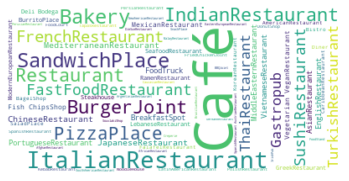

In [31]:
text = str()
for i in clusterZero['Venue Category']:
    text += i + ' '

# instantiate a word cloud object
clusterZeroWC = WordCloud(
    background_color='white',
    max_words=2000,
)

# generate the word cloud
clusterZeroWC.generate(text)

# display the word cloud
plt.imshow(clusterZeroWC, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Cluster One

In [32]:
clusterOne = ldnFood2.loc[ldnFood2['Cluster Labels'] == 1].drop('Cluster Labels', 1)
clusterOne

Borough                                     Venue Category
2       Bexley, London, UK  ItalianRestaurant GreekRestaurant Steakhouse C...
9     Dartford, London, UK  SandwichPlace Bakery BurgerJoint PizzaPlace Fa...
16      Harrow, London, UK  IndianRestaurant SandwichPlace IndianRestauran...
18  Hillingdon, London, UK  ChineseRestaurant FastFoodRestaurant FastFoodR...
19    Hounslow, London, UK  AsianRestaurant ChineseRestaurant IndianRestau...
31      Sutton, London, UK  ItalianRestaurant IndianRestaurant Bakery Fish...

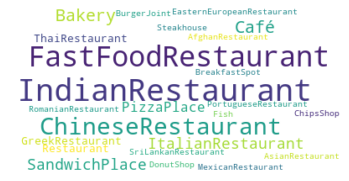

In [33]:
text = str()
for i in clusterOne['Venue Category']:
    text += i + ' '

# instantiate a word cloud object
clusterOneWC = WordCloud(
    background_color='white',
    max_words=2000,
)

# generate the word cloud
clusterOneWC.generate(text)

# display the word cloud
plt.imshow(clusterOneWC, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Cluster Two

In [34]:
clusterTwo = ldnFood2.loc[ldnFood2['Cluster Labels'] == 2].drop('Cluster Labels', 1)
clusterTwo

Borough  \
27                Newham, London, UK   
28             Redbridge, London, UK   
29  Richmond upon Thames, London, UK   
33        Waltham Forest, London, UK   

                                       Venue Category  
27  Café IndianRestaurant Fish&ChipsShop Bakery Fa...  
28  PizzaPlace ChineseRestaurant EasternEuropeanRe...  
29                   Café GermanRestaurant Café Diner  
33  Vegetarian/VeganRestaurant PizzaPlace TurkishR...

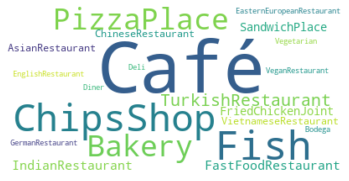

In [35]:
text = str()
for i in clusterTwo['Venue Category']:
    text += i + ' '

# instantiate a word cloud object
clusterTwoWC = WordCloud(
    background_color='white',
    max_words=2000,
)

# generate the word cloud
clusterTwoWC.generate(text)

# display the word cloud
plt.imshow(clusterTwoWC, interpolation='bilinear')
plt.axis('off')
plt.show()

## View most common venues in cluster.
Another way to visualise the most common venues in a cluster.

In [38]:
# add clustering labels
boroughVenues.insert(0, 'Cluster Labels', kmeans.labels_)
boroughVenues.head()

Cluster Labels                           Borough 1st Most Common Venue  \
0               0  Barking and Dagenham, London, UK    Chinese Restaurant   
1               0                Barnet, London, UK    Italian Restaurant   
2               1                Bexley, London, UK  Fast Food Restaurant   
3               0                 Brent, London, UK     Indian Restaurant   
4               0               Bromley, London, UK                  Café   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0     Indian Restaurant    Turkish Restaurant                 Diner   
1            Restaurant           Pizza Place    Chinese Restaurant   
2    Italian Restaurant      Greek Restaurant        Breakfast Spot   
3        Sandwich Place            Food Court            Restaurant   
4  Fast Food Restaurant        Sandwich Place    Italian Restaurant   

        5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0                        Café     Fish & Chips Shop  Ethiopian Restaurant   
1  Modern European Restaurant        Sandwich Place  Fast Food Restaurant   
2                  Steakhouse    Chinese Restaurant     Indian Restaurant   
3          Italian Restaurant    Chinese Restaurant   American Restaurant   
4                 Pizza Place      Sushi Restaurant                Bakery   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0         Deli / Bodega    Dim Sum Restaurant             Donut Shop  
1                Bakery        Breakfast Spot      Indian Restaurant  
2     French Restaurant    English Restaurant              Gastropub  
3                  Café          Burger Joint   Fast Food Restaurant  
4     Indian Restaurant          Burger Joint       Asian Restaurant

In [39]:
ldnMerged = ldnDF

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
ldnMerged = pd.merge(left = ldnMerged, right = boroughVenues, left_on = 'London Borough', right_on = 'Borough')
ldnMerged.head() # check the last columns!

London Borough  \
0  Barking and Dagenham, London, UK   
1                Barnet, London, UK   
2                Bexley, London, UK   
3                 Brent, London, UK   
4               Bromley, London, UK   

                                            Postcode   Latitude  Longitude  \
0     IG11, RM9, RM8, RM9, IG11, RM9, RM10, RM6, RM7  51.554117   0.150504   
1  EN5, NW7, NW7, EN5, EN5, NW2, NW4, N11, HA8, N...  51.653090  -0.200226   
2  SE2, DA5, DA14, DA7, DA1, DA17, DA5, DA6, DA7,...  51.441679   0.150488   
3  HA0, NW10, NW6, NW10, NW2, NW10, NW10, NW6, HA...  51.563826  -0.275760   
4  SE20, TN16, BR3, SE20, BR3, TN16, BR1, BR3, BR...  51.402805   0.014814   

   Cluster Labels                           Borough 1st Most Common Venue  \
0               0  Barking and Dagenham, London, UK    Chinese Restaurant   
1               0                Barnet, London, UK    Italian Restaurant   
2               1                Bexley, London, UK  Fast Food Restaurant   
3               0                 Brent, London, UK     Indian Restaurant   
4               0               Bromley, London, UK                  Café   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0     Indian Restaurant    Turkish Restaurant                 Diner   
1            Restaurant           Pizza Place    Chinese Restaurant   
2    Italian Restaurant      Greek Restaurant        Breakfast Spot   
3        Sandwich Place            Food Court            Restaurant   
4  Fast Food Restaurant        Sandwich Place    Italian Restaurant   

        5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0                        Café     Fish & Chips Shop  Ethiopian Restaurant   
1  Modern European Restaurant        Sandwich Place  Fast Food Restaurant   
2                  Steakhouse    Chinese Restaurant     Indian Restaurant   
3          Italian Restaurant    Chinese Restaurant   American Restaurant   
4                 Pizza Place      Sushi Restaurant                Bakery   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0         Deli / Bodega    Dim Sum Restaurant             Donut Shop  
1                Bakery        Breakfast Spot      Indian Restaurant  
2     French Restaurant    English Restaurant              Gastropub  
3                  Café          Burger Joint   Fast Food Restaurant  
4     Indian Restaurant          Burger Joint       Asian Restaurant

### Visualising Clusters on Map using Folium
Now we can create a map visualising the different clusters and their locations.

In [40]:
# Create map with clusters
latitude = 51.4975
longitude = 0.1357
mapClusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# Set color scheme for clusters
x = np.arange(numClusters)
ys = [i + x + (i*x)**2 for i in range(numClusters)]
colorsArray = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colorsArray]

# add markers to the map
markersColors = []
for lat, lon, poi, cluster in zip(ldnMerged['Latitude'], ldnMerged['Longitude'], ldnMerged['London Borough'], ldnMerged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(mapClusters)
       
mapClusters

### View Most Common Venues
Another way to visualise the most commonly occurring venues in each cluster. We can use this to find the differences in the clusters similarly to word clouds.

In [41]:
cluster1 = ldnMerged.loc[ldnMerged['Cluster Labels'] == 0, ldnMerged.columns[[1] + list(range(5, ldnMerged.shape[1]))]]
cluster1

Postcode  \
0      IG11, RM9, RM8, RM9, IG11, RM9, RM10, RM6, RM7   
1   EN5, NW7, NW7, EN5, EN5, NW2, NW4, N11, HA8, N...   
3   HA0, NW10, NW6, NW10, NW2, NW10, NW10, NW6, HA...   
4   SE20, TN16, BR3, SE20, BR3, TN16, BR1, BR3, BR...   
5                                                 WC1   
6   NW3, WC1, NW1, NW1, W1, NW3, NW5, NW3, NW3, N6...   
7                             EC3, EC1, EC4, EC4, WC2   
8   CR0, CR0, CR0, CR5, CR0, CR0, CR8, CR0, SW16, ...   
10  W3, W4, W4, W5, W13, UB6, W7, UB5, UB2, UB6, U...   
11  N11, N14, EN2, EN3, EN2, EN3, EN2, N9, N18, EN...   
12  SE3, SE12, SE7, SE9, SE10, SE12, SE3, SE10, SE...   
13  E8, E5, E8, E9, N1, N16, E8, E9, E9, E2, E9, N...   
14        SW6, W6, NW10, SW6, SW6, W12, W14, W12, W12   
15  N11, N22, N22, N8, N4, N10, N4, N8, N15, N8, N...   
17  RM11, RM5, RM5, RM14, RM12, RM11, RM2, RM3, RM...   
20                                                EC1   
21  EC1, N1, N19, N1, N1, EC1, N1, EC1, N5, N7, N1...   
22  SW3, SW5, SW10, W8, W11, W14, SW7, W10, W11, W...   
23  KT5, KT9, KT2, KT9, SW15, KT1, KT2, KT9, KT3, ...   
24  SW2, SW9, SE5, SW4, SE19, SE27, SE24, SE11, SE...   
25  SE6, SE3, SE4, SE6, SE12, SE4, SE8, BR1, SE23,...   
26  SW19, SM4, SW19, CR4, SM4, SM4, SW20, SW19, SM...   
30  SE1, SE1, SE5, SE5, SE21, SE22, SE1, SE11, SE1...   
32  E2, E14, E3, E3, E2, E14, E14, E14, E14, E14, ...   
34  SW12, SW11, SW18, SW8, SW15, SW15, SW18, SW19,...   
35  WC2, W2, SW1, WC2, W1, WC2, SW1, NW8, W9, W2, ...   

                               Borough 1st Most Common Venue  \
0     Barking and Dagenham, London, UK    Chinese Restaurant   
1                   Barnet, London, UK    Italian Restaurant   
3                    Brent, London, UK     Indian Restaurant   
4                  Bromley, London, UK                  Café   
5     Camden and Islington, London, UK                  Café   
6                   Camden, London, UK    Italian Restaurant   
7                     City, London, UK    Italian Restaurant   
8                  Croydon, London, UK        Sandwich Place   
10                  Ealing, London, UK                  Café   
11                 Enfield, London, UK                  Café   
12               Greenwich, London, UK                  Café   
13                 Hackney, London, UK                  Café   
14  Hammersmith and Fulham, London, UK                  Café   
15                Haringey, London, UK    Turkish Restaurant   
17                Havering, London, UK    Italian Restaurant   
20        Islington & City, London, UK                  Café   
21               Islington, London, UK                  Café   
22  Kensington and Chelsea, London, UK                  Café   
23    Kingston upon Thames, London, UK                  Café   
24                 Lambeth, London, UK                  Café   
25                Lewisham, London, UK                  Café   
26                  Merton, London, UK  Fast Food Restaurant   
30               Southwark, London, UK    Italian Restaurant   
32           Tower Hamlets, London, UK    Italian Restaurant   
34              Wandsworth, London, UK           Pizza Place   
35             Westminster, London, UK                  Café   

   2nd Most Common Venue     3rd Most Common Venue      4th Most Common Venue  \
0      Indian Restaurant        Turkish Restaurant                      Diner   
1             Restaurant               Pizza Place         Chinese Restaurant   
3         Sandwich Place                Food Court                 Restaurant   
4   Fast Food Restaurant            Sandwich Place         Italian Restaurant   
5              Gastropub  Mediterranean Restaurant                     Bakery   
6            Pizza Place                      Café               Burger Joint   
7       Sushi Restaurant                      Café         English Restaurant   
8   Fast Food Restaurant                      Café          Indian Restaurant   
10    Italian Restaurant                    Bak

In [42]:
cluster2 = ldnMerged.loc[ldnMerged['Cluster Labels'] == 1, ldnMerged.columns[[1] + list(range(5, ldnMerged.shape[1]))]]
cluster2

Postcode                 Borough  \
2   SE2, DA5, DA14, DA7, DA1, DA17, DA5, DA6, DA7,...      Bexley, London, UK   
9                                                 DA5    Dartford, London, UK   
16  HA3, HA7, HA1, HA1, HA3, HA5, HA1, HA2, HA5, H...      Harrow, London, UK   
18  UB8, HA5, HA4, UB9, UB3, UB7, UB3, UB4, UB8, U...  Hillingdon, London, UK   
19  TW8, W4, TW5, TW14, TW13, TW14, W4, W4, TW13, ...    Hounslow, London, UK   
31  SM6, CR0, SM2, SM5, SM1 (PARTIAL)SM2, SM3, SM1...      Sutton, London, UK   

   1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
2   Fast Food Restaurant    Italian Restaurant      Greek Restaurant   
9      Indian Restaurant           Pizza Place    Chinese Restaurant   
16     Indian Restaurant  Fast Food Restaurant       Thai Restaurant   
18  Fast Food Restaurant    Chinese Restaurant      Greek Restaurant   
19     Indian Restaurant  Fast Food Restaurant    Chinese Restaurant   
31    Chinese Restaurant     Indian Restaurant    Italian Restaurant   

   4th Most Common Venue 5th Most Common Venue  6th Most Common Venue  \
2         Breakfast Spot            Steakhouse     Chinese Restaurant   
9                   Café  Fast Food Restaurant       Greek Restaurant   
16     Afghan Restaurant            Restaurant  Sri Lankan Restaurant   
18  Ethiopian Restaurant      Cuban Restaurant          Deli / Bodega   
19                  Café        Sandwich Place                 Bakery   
31                Bakery     Fish & Chips Shop            Wings Joint   

   7th Most Common Venue  8th Most Common Venue 9th Most Common Venue  \
2      Indian Restaurant      French Restaurant    English Restaurant   
9           Burger Joint     Italian Restaurant                Bakery   
16                Bakery         Sandwich Place   Empanada Restaurant   
18    Dim Sum Restaurant                  Diner            Donut Shop   
19    Italian Restaurant  Portuguese Restaurant   Romanian Restaurant   
31    Falafel Restaurant     Dim Sum Restaurant                 Diner   

   10th Most Common Venue  
2               Gastropub  
9          Sandwich Place  
16       Cuban Restaurant  
18    Dumpling Restaurant  
19             Restaurant  
31             Donut Shop

In [43]:
cluster3 = ldnMerged.loc[ldnMerged['Cluster Labels'] == 2, ldnMerged.columns[[1] + list(range(5, ldnMerged.shape[1]))]]
cluster3

Postcode  \
27  E6, E16, IG11, E16, E16, E6, E7, E12, E12, E15...   
28  IG2, IG6, RM6, IG2, IG3, IG7, IG1, IG1, IG2, I...   
29  SW13, SW13, SW14, TW1, TW11, TW12, TW10, TW12,...   
33          E11, E4, E4, E10, E15, E11, E17, E17, E17   

                             Borough 1st Most Common Venue  \
27                Newham, London, UK                  Café   
28             Redbridge, London, UK                  Café   
29  Richmond upon Thames, London, UK                  Café   
33        Waltham Forest, London, UK                  Café   

   2nd Most Common Venue          3rd Most Common Venue  \
27                Bakery              Fish & Chips Shop   
28           Pizza Place             Chinese Restaurant   
29     German Restaurant                          Diner   
33    Turkish Restaurant  Vegetarian / Vegan Restaurant   

          4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
27        Vietnamese Restaurant     Indian Restaurant      Asian Restaurant   
28  Eastern European Restaurant    English Restaurant              Creperie   
29                  Wings Joint    Falafel Restaurant         Deli / Bodega   
33                Deli / Bodega           Pizza Place           Wings Joint   

   7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
27   Fried Chicken Joint        Sandwich Place  Fast Food Restaurant   
28      Cuban Restaurant         Deli / Bodega    Dim Sum Restaurant   
29    Dim Sum Restaurant            Donut Shop   Dumpling Restaurant   
33    English Restaurant              Creperie      Cuban Restaurant   

         10th Most Common Venue  
27           English Restaurant  
28                        Diner  
29  Eastern European Restaurant  
33           Dim Sum Restaurant

## London Rental Prices
This section will look at rental costs in different areas of London. As labelled in the data section, the data can be found from the Gov UK website. Let's first load it to a dataframe.

In [49]:
rentDF = pd.read_excel('London Rent Data.xls', sheet_name = 'Raw data', skiprows = 2)
rentDF.head()

Year Quarter       Code                  Area Category Count of rents  \
0  2011      Q2  E09000001        City of London     Room              -   
1  2011      Q2  E09000002  Barking and Dagenham     Room             92   
2  2011      Q2  E09000003                Barnet     Room            945   
3  2011      Q2  E09000004                Bexley     Room            119   
4  2011      Q2  E09000005                 Brent     Room            344   

  Average Lower quartile Median Upper quartile  
0       -              -      -              -  
1     336            282    347            390  
2     450            399    433            500  
3     390            347    390            433  
4     469            390    457            550

Looking at a quick summary of the data, notice the following things
+ Not all of the data we expect to be numeric is numeric (average, count of rents etc.)  
+ The latest data is for the year 2019.

In [50]:
rentDF.describe(include = 'all')

Year Quarter       Code                  Area Category  \
count   6160.000000    6160       6160                  6160     6160   
unique          NaN       4         44                    44        7   
top             NaN      Q1  E09000028  Richmond upon Thames   Studio   
freq            NaN    2464        140                   140      880   
mean    2014.300000     NaN        NaN                   NaN      NaN   
std        2.532003     NaN        NaN                   NaN      NaN   
min     2011.000000     NaN        NaN                   NaN      NaN   
25%     2012.000000     NaN        NaN                   NaN      NaN   
50%     2014.000000     NaN        NaN                   NaN      NaN   
75%     2016.250000     NaN        NaN                   NaN      NaN   
max     2019.000000     NaN        NaN                   NaN      NaN   

        Count of rents Average  Lower quartile  Median  Upper quartile  
count           6160.0    6160          6160.0  6160.0          6160.0  
unique          2556.0    2259           745.0   840.0           819.0  
top               40.0       -           750.0  1300.0          1300.0  
freq              63.0      43           159.0   178.0           174.0  
mean               NaN     NaN             NaN     NaN             NaN  
std                NaN     NaN             NaN     NaN             NaN  
min                NaN     NaN             NaN     NaN             NaN  
25%                NaN     NaN             NaN     NaN             NaN  
50%                NaN     NaN             NaN     NaN             NaN  
75%                NaN     NaN             NaN     NaN             NaN  
max                NaN     NaN             NaN     NaN             NaN

In [51]:
# Drop rows with non-numeric data
indexes = rentDF.loc[rentDF['Count of rents'] == '-'].index
rentDF.drop(indexes, inplace = True)

indexes = rentDF.loc[rentDF['Average'] == '.'].index
rentDF.drop(indexes, inplace = True)

In [55]:
# Create new dataframe from latest data in 2019.
latestDF = rentDF.loc[rentDF['Year'] == 2019]

# Convert data types to integer.
latestDF[['Average']] = latestDF[['Average']].astype(int)

/Users/christian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Group the data by area to find the average values for each area of London. Many rows with same area become one with mean average rental price.

In [56]:
# Group by area to find average
latestDF2 = latestDF.groupby('Area').mean().reset_index()
latestDF2.head()

Area    Year      Average
0  Barking and Dagenham  2019.0  1111.142857
1                Barnet  2019.0  1512.571429
2                Bexley  2019.0  1002.285714
3                 Brent  2019.0  1459.285714
4               Bromley  2019.0  1240.714286

In [57]:
# Read location lat, long values saved earlier.
areaDF = pd.read_csv('LDN_Coords.csv')
areaDF.head()

Unnamed: 0                    London Borough  \
0           0  Barking and Dagenham, London, UK   
1           1                Barnet, London, UK   
2           2                Bexley, London, UK   
3           3                 Brent, London, UK   
4           4               Bromley, London, UK   

                                            Postcode   Latitude  Longitude  
0     IG11, RM9, RM8, RM9, IG11, RM9, RM10, RM6, RM7  51.554117   0.150504  
1  EN5, NW7, NW7, EN5, EN5, NW2, NW4, N11, HA8, N...  51.653090  -0.200226  
2  SE2, DA5, DA14, DA7, DA1, DA17, DA5, DA6, DA7,...  51.441679   0.150488  
3  HA0, NW10, NW6, NW10, NW2, NW10, NW10, NW6, HA...  51.563826  -0.275760  
4  SE20, TN16, BR3, SE20, BR3, TN16, BR1, BR3, BR...  51.402805   0.014814

### Visualising Choropleth Map
We use the GeoJSON file that contains London Borough boundaries to plot a choropleth map again using Folium.

In [58]:
# Create a map of London using latitude and longitude values found above
latitude = 51.5156177
longitude = -0.0919983
MapLondon = folium.Map(location = [latitude, longitude], zoom_start = 10)

In [59]:
londonGEO = r'london_boroughs.json'

In [60]:
# generate choropleth map
MapLondon.choropleth(
    geo_data=londonGEO,
    data=latestDF2,
    columns=['Area', 'Average'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Rental Prices in London'
)

# display map
MapLondon

### Imposing on Cluster Map
Now we merge the two map visualisations together to view clustered data points on the choropleth map.

In [61]:
# add markers to the map
markersColors = []
for lat, lon, poi, cluster in zip(ldnMerged['Latitude'], ldnMerged['Longitude'], ldnMerged['London Borough'], ldnMerged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(MapLondon)

# display map
MapLondon